# RTF model for predicting racket age using datasets P1, P2, and P3, based on **MFCC** - Vibration

### Model Description

This notebook implements a RTF model to predict the age of a racket (RV, RR, RB) based on sound features extracted from vibration datasets. The workflow involves reading `.csv` files, **MFCC** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through plots of normalized spectrum and band energies.

### Import libraries

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
import librosa
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
# import openpyxl

### Import Tools Functions

In [2]:
import sys
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

MFCC

# Main

In [3]:
import ast

# Read the CSV file
df_combined = pd.read_csv("../../../Data/Vibration/All_Data_combinedv3.csv")


df_combined.head()

,Raw Signal Ch0,Spectrum,freqs,File Name,Position,Racket Type,Age
0,[-0.01573961 -0.02470204 -0.0184555 ... -6.36...,"[5415.435319490299, 3187.673624625387, 2567.48...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_1.csv,C,RB,1
1,[ 0.10185837 0.10090781 0.08882211 ... -6.35...,"[3574.0039456266313, 2253.172677296551, 2189.4...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_2.csv,C,RB,1
2,[-0.02701054 -0.01506063 -0.02510942 ... -6.09...,"[4336.317505980091, 2636.183071505374, 2297.29...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_3.csv,C,RB,1
3,[-0.05687327 -0.06352719 -0.05049093 ... -9.29...,"[7218.047965980523, 4371.60331681831, 3234.473...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_S_1.csv,S,RB,1
4,[-0.08674804 -0.04994775 -0.05334261 ... -8.81...,"[6351.72555524914, 3431.4594161592727, 3006.71...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_S_2.csv,S,RB,1


In [4]:
# Compute the feature
freqs = np.array(ast.literal_eval(df_combined["freqs"].iloc[0]))  # Convert string to numpy array

mfcc_list=[]
band_frequencies_list=[]

for spectrum in df_combined["Spectrum"]:
    spectrum_list = np.array(ast.literal_eval(spectrum))
    mfcc = librosa.feature.mfcc(y=spectrum_list, sr=20000, n_mfcc=20)  
    mfcc_list.append(mfcc)



df_combined["mfcc"]=mfcc_list


c:\Users\hugom\anaconda3\envs\IAConda\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=102
  warnings.warn(


In [5]:
# Determine the minimum number of samples for each age group
min_samples_per_age = df_combined['Age'].value_counts().min()

# Create a new DataFrame with equal samples for each age group
df_sorted_homogeneous = (
    df_combined.groupby('Age')
    .apply(lambda x: x.sample(n=min_samples_per_age, random_state=42))
    .reset_index(drop=True)
)

# df_sorted_homogeneous

# Verify the distribution
print(df_sorted_homogeneous['Age'].value_counts())




X = df_sorted_homogeneous["mfcc"].tolist()
X = [mfcc.flatten() for mfcc in X]

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_sorted_homogeneous["Age"])


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Age
1    216
2    216
3    216
Name: count, dtype: int64


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Define the ranges for hyperparameters
n_estimators_range = range(1, 21)  # Number of estimators (trees)
criterion_options = ['gini', 'entropy', 'log_loss']  # Splitting criteria

# List to store the results
results = []

# Test all combinations of hyperparameters
for n_estimators in n_estimators_range:
    for criterion in criterion_options:
        # Create and train the Random Forest model
        rtf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, random_state=42)
        rtf.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = rtf.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred)

        # Evaluate on the training set
        y_train_pred = rtf.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)

        # Add the results to the list
        results.append({
            'n_estimators': n_estimators,
            'criterion': criterion,
            'accuracy_train': accuracy_train,
            'accuracy_test': accuracy_test
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

print(results_df)


    n_estimators criterion  accuracy_train  accuracy_test
0              1      gini        0.861004       0.630769
1              1   entropy        0.886100       0.638462
2              1  log_loss        0.886100       0.638462
3              2      gini        0.893822       0.630769
4              2   entropy        0.866795       0.715385
5              2  log_loss        0.866795       0.715385
6              3      gini        0.957529       0.707692
7              3   entropy        0.951737       0.669231
8              3  log_loss        0.951737       0.669231
9              4      gini        0.972973       0.715385
10             4   entropy        0.955598       0.730769
11             4  log_loss        0.955598       0.730769
12             5      gini        0.978764       0.700000
13             5   entropy        0.971042       0.738462
14             5  log_loss        0.971042       0.738462
15             6      gini        0.982625       0.738462
16            

## Results and Visualisation

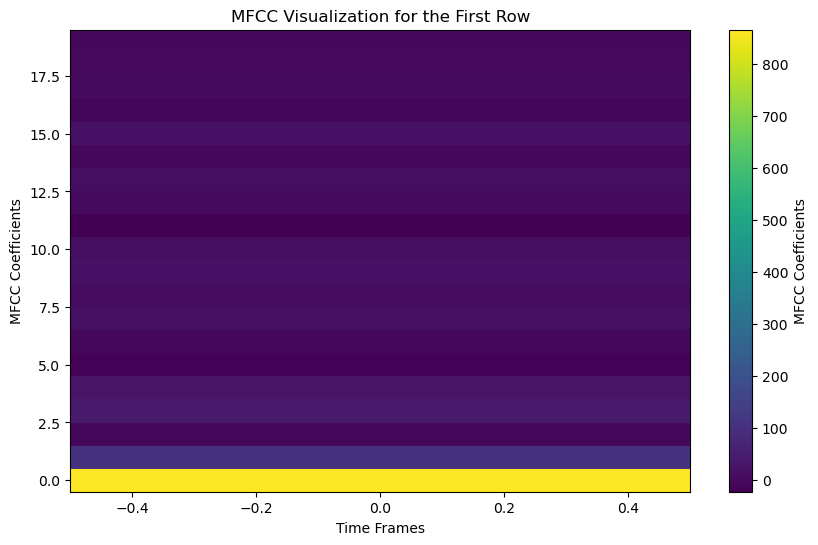

In [7]:
# Extract the MFCC values from the first row
mfcc_values = df_combined.iloc[0]["mfcc"]

# Plot the MFCC
plt.figure(figsize=(10, 6))
plt.imshow(mfcc_values, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='MFCC Coefficients')
plt.title('MFCC Visualization for the First Row')
plt.xlabel('Time Frames')
plt.ylabel('MFCC Coefficients')
plt.show()
